In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train.csv")
X_test = pd.read_csv(f"{base_url}/X_test.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 13) (8639, 13)
(34554, 1) (8639, 1)


# Feature Engineering

First, lets create a column named `Customer value` based on balance, previous campaign contacts, and penalties for active loans.

In [3]:
# Calculation of customer value score 
total_loans = X_train.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)
X_train['customer_value_score'] = X_train['balance'] * (1 + X_train['previous']) - (total_loans * 1000)

total_loans = X_test.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)
X_test['customer_value_score'] = X_test['balance'] * (1 + X_test['previous']) - (total_loans * 1000)

`balance * (1 + X_train['previous'])`: This amplifies the impact of a client's balance based on their past engagement (previous contacts). Clients with a higher balance and a history of interactions are assumed to have more value, which aligns with real-world behavior.

`total_loans * 1000`: Deducting 1000 for each loan reflects the idea that customers with loans might have less disposable income, reducing their overall value.

In general, the formula accounts for both wealth and behavior, dynamically scaling a customer's value based on their interactions.

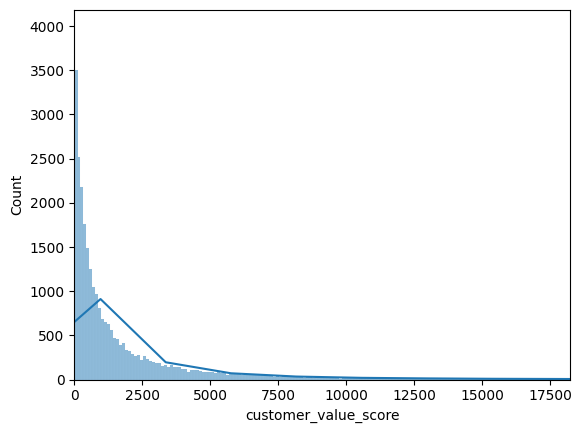

In [4]:
# Lets examine the distribution of 'customer_value_score' column
sns.histplot(X_train['customer_value_score'], kde=True)
plt.xlim(0, X_train['customer_value_score'].quantile(0.98))
plt.show()

To deal with skewness, lets apply log transformation and check whether it helped compress the skewness

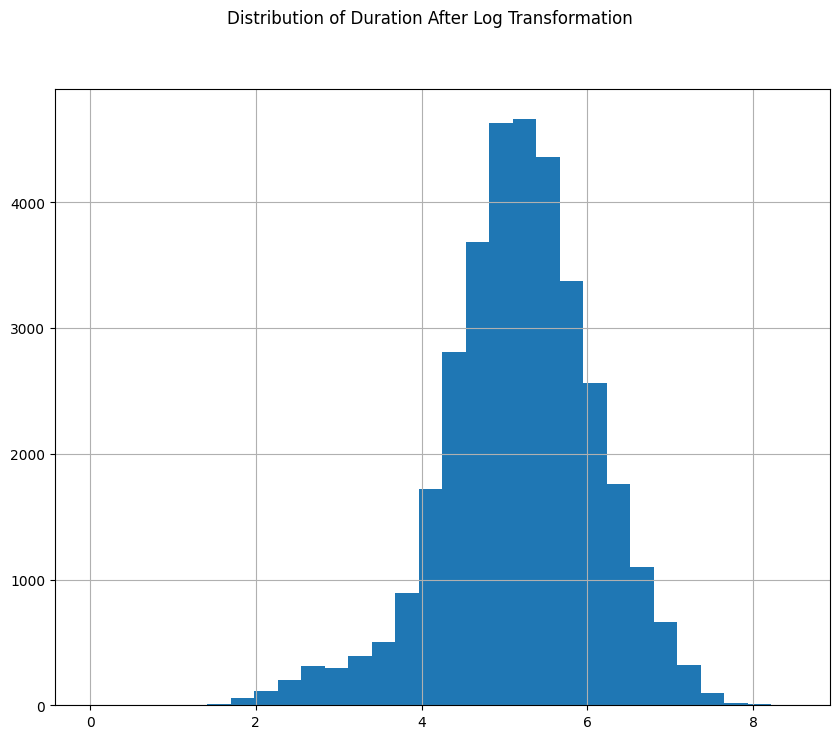

In [5]:
# Apply the log transformation
X_train['duration'] = np.log(X_train['duration']+1)
X_test['duration'] = np.log(X_test['duration']+1)

# Plot histograms for transformed features
X_train['duration'].hist(bins=30, figsize=(10, 8))
plt.suptitle("Distribution of Duration After Log Transformation")
plt.show()


It also seems reasonable to create an `estimated_income` variable since it shows a customers financial situation.
The feature will be based on their job, education, balance and loans becasue:
- `balance`: A higher balance likely indicates higher financial stability or disposable income, so using it as a base is logical.
- `job`: Assigning weights based on job ranking reflects the assumption that certain jobs are typically associated with higher income levels (e.g., management vs. blue-collar work).
- `education`: Higher education levels often correlate with higher earning potential, making this a valid inclusion.
- Loans (`housing` and `personal`): Penalizing for loans acknowledges that clients with loans may have less disposable income, which could affect their financial health.

In [6]:
# Job ranking
job_ranking = {
    'management': 5, 'admin.': 4, 'technician': 4, 'entrepreneur': 4, 
    'blue-collar': 3, 'services': 3, 'self-employed': 4, 'retired': 2, 
    'student': 1, 'unemployed': 1, 'housemaid': 2, 'unknown': 1
}

# Education ranking
education_ranking = {
    'tertiary': 3,  # University level
    'secondary': 2,  # High school level
    'primary': 1,  # Primary school level
    'unknown': 1  # Unknown education level
}

# Proxy feature for loans (both housing and personal loan)
total_loans = X_train.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)

# Calculating estimated income using balance, job, education, and loans
X_train['estimated_income'] = (
    X_train['balance'] * 1 +  # Balance weight
    X_train['job'].map(job_ranking) * 5000 +  # Job weight
    X_train['education'].map(education_ranking) * 1000 -  # Education weight
    total_loans * 1000  # Loan penalty
)

In [7]:
# Repeat the same for test set
total_loans = X_test.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)

# Calculating estimated income using balance, job, education, and loans
X_test['estimated_income'] = (
    X_test['balance'] * 1 +  # Balance weight
    X_test['job'].map(job_ranking) * 5000 +  # Job weight
    X_test['education'].map(education_ranking) * 1000 -  # Education weight
    total_loans * 1000  # Loan penalty
)

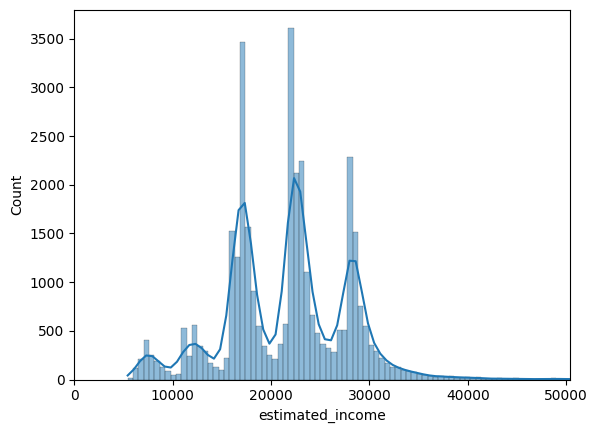

In [8]:
# Lets examine the distribution of 'estimated_income' column
sns.histplot(X_train['estimated_income'], kde=True)
plt.xlim(0, X_train['estimated_income'].quantile(0.998))
plt.show()


The formula also introduces domain-specific knowledge, providing a richer feature that reflects real-world dynamics between income, job roles, education, and debt. `balance` is a strong indicator of financial health and is directly proportional to disposable income or wealth. `job` type often correlates with income level. For example:
- Higher-ranked jobs like management and technician are weighted more heavily, assuming they have higher earning potential.
- Lower-ranked jobs like housemaid or unemployed are weighted less.

Higher `education` levels (e.g., tertiary) are assumed to increase earning potential, while lower levels (e.g., primary) contribute less. `Loans` are a financial liability that reduce disposable income, so this penalty accounts for reduced financial capacity.

Binning might help capture non-linear relationships. Continuous variables may have non-linear relationships with the target. For instance, the effect of `age` might differ significantly between younger and older clients, which binning can help capture. `previous`, on the other hand, distinguishes between clients who were highly engaged in past campaigns (high) versus those who were not contacted at all (none).

In [10]:
# Binning 
X_train['age_bin'] = pd.cut(X_train['age'], bins=[18, 30, 50, 70,X_train['age'].max()], labels=['Young (18-30)', 'Middle-aged (31-50)', 'Senior (51-70)', 'Elderly (71+)'])
X_train['previous_bin'] = pd.cut(X_train['previous'], bins=[-1, 0, 2, 5, np.inf], labels=['none', 'low', 'medium', 'high'])

X_test['age_bin'] = pd.cut(X_test['age'], bins=[18, 30, 50, 70,X_test['age'].max()], labels=['Young (18-30)', 'Middle-aged (31-50)', 'Senior (51-70)', 'Elderly (71+)'])
X_test['previous_bin'] = pd.cut(X_test['previous'], bins=[-1, 0, 2, 5, np.inf], labels=['none', 'low', 'medium', 'high'])

In [11]:
X_train.to_csv("X_train_fe.csv", index=False)
X_test.to_csv("X_test_fe.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Datasets successfully exported as CSV files.")

Datasets successfully exported as CSV files.


In [12]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,age_bin,previous_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,Senior (51-70),none
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,Middle-aged (31-50),low
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,Middle-aged (31-50),none
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,Young (18-30),none
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,Senior (51-70),none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,60,retired,married,secondary,2060,0,0,cellular,4.912655,95,4,failure,29-jun,10300,14060,Senior (51-70),medium
34550,32,management,single,tertiary,0,0,0,cellular,4.060443,-1,0,other,19-nov,0,28000,Middle-aged (31-50),none
34551,38,blue-collar,married,primary,0,0,0,unknown,5.347108,-1,0,other,13-may,0,16000,Middle-aged (31-50),none
34552,30,admin.,single,secondary,154,1,0,cellular,3.218876,-1,0,other,21-nov,154,22154,Young (18-30),none
